# Linear Regression

Linear regression was invented at the beginning of the 19th century and today, after more than 200 years, it is still used extensively in practical applications for description and prediction purposes:

- In econometrics, it is useful to estimate the price elasticity of a particular product by regressing sales revenue on price and possibly other features such as demographics and competitor and retail information.
- In health sciences, it can be applied to predict how long a patient will remain (i.e. length of stay) in the ER of a hospital based on patient information, triage assessment, medical test results, and the date/time of arrival.
- In social sciences, it may shed light on future academic performance of students, so proactive measures can be taken to improve their learning outcomes.

In general, linear regression is used to model the relationship between a continuous variable and other explanatory variables, which can be either continuous or categorical. When applying this technique, finding the subset of features that maximizes its perfomance is often of interest.

<!-- ---
## Recap

Linear regression assumes that there is a linear relationship between the feature vector $x_i \in \mathbb{R}^d$ and the response $y_i \in \mathbb{R}$. Mathematically speaking, for sample $i$ we have $y_i = \mathbf{w}^{\top} x_i + b$, where $\mathbf{w} \in \mathbb{R}^d$ is the vector of feature weights and $b$ is the intercept (the constant term). 
We can learn the weights from a training set with $n$ observations by minimizing the Residual Sum of Squares (RSS). Mathematically:

\begin{equation}
RSS = \sum_{i=1}^{n} (y_i - (\mathbf{w}^{\top} x_{i} + b))^2
\end{equation}

In practice, **some of the features are in fact not associated with the response**. By including them, we only add unnecessary complexity to the model and increase variance to the weight estimates. However, finding the best performing model is no simple task as there is an exponential number of candidates, as one has to test $\sum_{s=1}^{d-1}{{d-1} \choose s}$ models. <br> Since OLS rarely yields estimates that are exactly zero, thus discarding the features related to them, we need to resort to feature selection methods. Popular methods include:

- Subset selection, e.g. stepwise selection.
- **Dimensionality reduction**, e.g. principal component regression.
- **Shrinkage**, e.g. the Lasso.

The Lasso fits a model containing all $d$ predictors, while incorporating a budget constraint based on the L1-norm of $\beta$, disregarding the intercept component. In fact, this method minimizes the RSS, subject to $\sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose| \leq s$, where $s$ is a hyper-parameter representing the budget that is usually tuned via cross-validation. This constraint has the effect of shrinking all weight estimates, allowing some of them to be exactly zero when $s$ is small enough. Finally, it is worth noting that the unconstrained version of the Lasso is more frequently used. This version solves an unconstrained optimization problem where $RSS + \lambda \sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose|$ is minimized. 

A similar formulation is now presented, where the **L0-norm (number of non zero terms)** is used instead. We now seek to minimize the RSS, subject to $\sum_{l=1}^{d-1}I(\beta_l \neq 0) \leq s$, where $I(\beta_l \neq 0)$ is an indicator function taking on the value of 1 if $\beta_j \neq 0$ and $0$ otherwise. In this setting, $s$ represents the number of features to consider in the model. This optimization problem may be casted as a Mixed Integer Quadratic Program (MIQP). 

> Traditionally, the feature selection problem has not been tackled this way because of the common belief in the statistics community that large-scale problems are intractable. But this is no longer the case, considering the computing power currently available and the performance of modern optimization solvers such as Gurobi.

 -->
---
## Case study: Optimal Feature Selection

The goal of feature selection is to find a small set of the features in the data that best predict the outcome. Mathematically, the problem being solved is:

\begin{equation}\label{eq:fs}
     \min_{\mathbf{w}, b} \sum_{i=1}^{n} loss(y_i, \mathbf{w}^{\top} x_{i} + b) + \frac{1}{2 \gamma} \|\mathbf{w}\|_2^2 \\ \quad s.t. \, \|\mathbf{w}\|_0 <= k
\end{equation}


We are trying to fit a linear model ($\mathbf{w}, b$) to the training data. The first term calculates the error made by the model when applied to the training data for a specified scoring function $loss$. The second term is a regularization term added to prevent overfitting and make the model robust to perturbations in the data. The constraint restricts the model to selecting at most $k$ of the features in the data - the coefficients for all other features are zero.


Depending on the choice of the scoring criterion $loss$ used in the first term, this problem represents many classical problems in machine learning:

- classification:
    - the entropy criterion leads to logistic regression: $loss = −\sum_{i=1}^{n} \log(p_{i{y_i}})$.
    - the L1 hinge loss criterion leads to support vector machines
    - the L2 hinge loss criterion leads to L2 support vector machines


- regression:
    - the mean-squared error (MSE) criterion leads to linear regression: $\text{MSE}=\frac{1}{n}\sum_{i=1}^{n}{(y_i - (\mathbf{w}^{T} x_{i} + b))^2}$
    - the L1 hinge loss criterion leads to L1 support vector regression
    - the L2 hinge loss criterion leads to L2 support vector regression

## Solution Approach: regression with MSE

We now present a MIQP formulation that finds the weight estimates for a linear regression problem, where at least $k$ of those weights must be zero:

### Sets and Indices:

- $i \in I=\{1,2,\dots,n\}$: Set of observations (length of the dataset).

- $j \in J=\{1,2,\dots,d\}$: Set of features.

- $k \in J $: number of weights to set to zero.

### Parameters:

- $k \in \mathbb{N}$: Number of features to exclude from the model.

- $Q = X^T X \in \mathbb{R}^{dxd}$: Quadratic component of the objective function.

- $c = y^TX \in \mathbb{R}^{d}$: Linear component of the objective function.

- $z = y^T y \in \mathbb{R}$: Constant component of the objective function.


### Decision Variables:

- $\mathbf{w}_j \in \mathbb{R}$: Weight of feature $j$, representing the change in the response variable per unit-change of feature $j$.
- $zero_j \in \{0,1\}$: 1 if the weight of feature $j$ is zero, 0 otherwise.

### Objective Function:

- **Training error**: Minimize the Residual Sum of Squares (RSS):

\begin{equation}
\text{Min} \quad Z = \sum_{j \in J}\sum_{j' \in J}Q_{j,j'}\mathbf{w}_j\mathbf{w}_{j'} - 2 \sum_{j \in J}c_j\mathbf{w}_j + z
\tag{0}
\end{equation}

Note that we use the fact that if $x^*$ is a minimizer of $f(x)$, it is also a minimizer of $a\cdot f(x)$, as long as $a > 0$.

### Constraints:

- **Mutual exclusivity**: For each feature $j$, if $zero_j=1$, then $\mathbf{w}_j=0$ (defined as a Special Ordered Set of type one):

\begin{equation}
(\mathbf{w}_j, zero_j): \text{SOS}_1 \quad \forall j \in J
\tag{1}
\end{equation}
> A Special-Ordered Set is a highly specialized constraint that places restrictions on the values that variables in a given list can take. There are two types of SOS constraints. In an SOS constraint of type 1 (an $SOS_1$ constraint), at most one variable in the specified list is allowed to take a non-zero value. In an SOS constraint of type 2 (an $SOS_2$ constraint), at most two variables in the specified, ordered list are allowed to take a non-zero value, and those non-zero variables must be contiguous in the list. The variables in an SOS constraint can be continuous, integer, or binary..

- **Budget constraint**: At least $k$ feature weights must be equal to zero:

\begin{equation}
\sum_{j \in J} zero_j \geq k
\tag{2}
\end{equation}

---
# Python Implementation


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Model

In [101]:
import gurobipy as gp
from gurobipy import GRB
from itertools import product

def make_model(X, y, k, reg_type="OLS", alpha=0.1):
    assert k < X.shape[1], "Too large k!"
    regressor = gp.Model()
    
    # Append a column to the feature matrix to account for the y-intercept
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)  
    dim = X.shape[1]
    
    # Decision variables
    w = regressor.addVars(dim, lb=-GRB.INFINITY, name="weights")
    zero = regressor.addVars(dim - 1, vtype=GRB.BINARY, name="zero")
    
    # Constraint sets
    for i in range(dim - 1):
        regressor.addSOS(GRB.SOS_TYPE1, [w[i], zero[i]])
        
    # Budget constraint
    regressor.addConstr(zero.sum() >= k) 
    
    # Objective Function:
    Q, c = np.dot(X.T, X), np.dot(y.T, X)
    obj = sum(Q[i,j] * w[i] * w[j] for i, j in product(range(dim), repeat=2))
    obj -= 2 * sum(c[j] * w[j] for j in range(dim))
    obj += np.dot(y, y)
    
    # Regularization
    if reg_type == "L0":
        obj += alpha * (dim - zero.sum() - 1)
    if reg_type == "L1":
        w_abs = regressor.addVars(dim - 1, lb=0, name="w_abs")
        for j in range(dim - 1):
            regressor.addGenConstrAbs(w_abs[j], w[j], "abs_constr")
        obj += alpha * w_abs.sum()
    regressor.setObjective(obj, GRB.MINIMIZE)
    
    regressor.params.OutputFlag = 0
    regressor.params.timelimit = 60
    regressor.params.mipgap = 0.001
    return regressor, w

## Dataset

The Boston dataset is used for this purpose. This dataset measures the prices of 506 houses, along with 13 features that provide insights about their neighbourhoods. We will use the original feature terminology, so the interested reader can visit [this website](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) for more information.

Note that 20% of the samples are reserved for computing the out-of-sample MSE. The resulting metrics are displayed in a bar chart (shown below) to facilitate the comparison between models.

In [102]:
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split

# Load data
boston = load_boston()
#boston = fetch_california_housing()

boston.keys()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [103]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [52]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [53]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [54]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


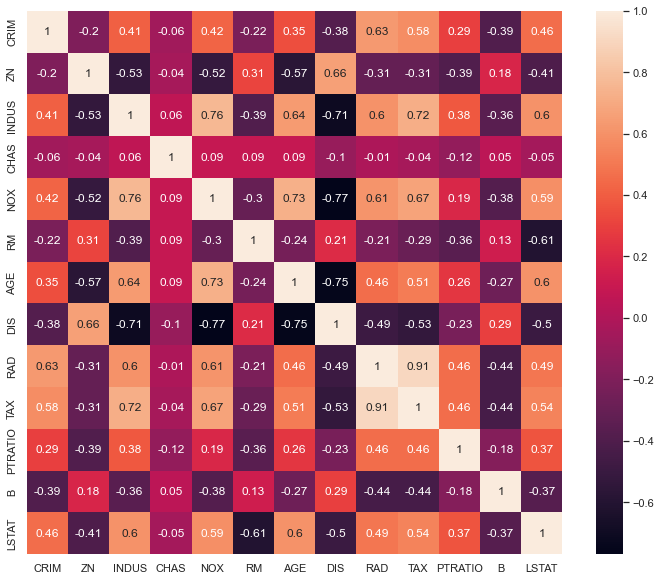

In [11]:
import seaborn as sns; sns.set()
plt.figure(figsize=(12, 10))
sns.heatmap(data=boston_df.corr().round(2), annot=True)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


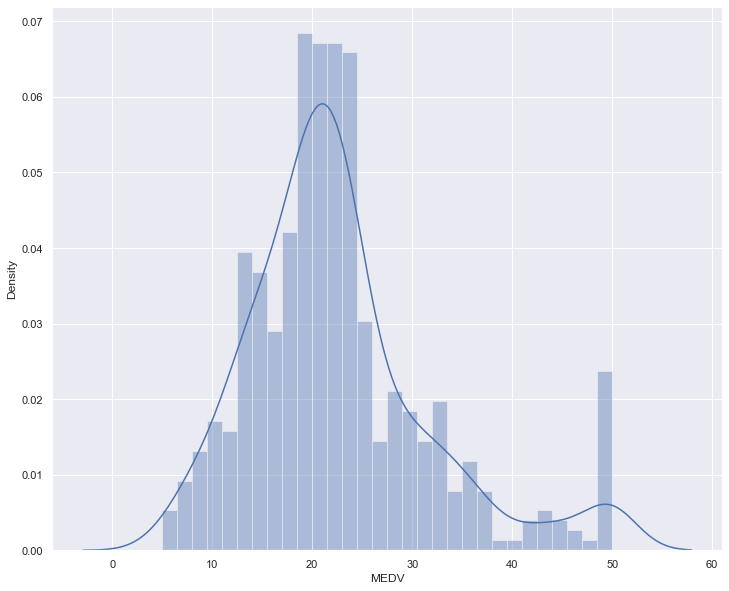

In [12]:
boston_df['MEDV'] = boston.target

plt.figure(figsize=(12, 10))
sns.distplot(boston_df['MEDV'], bins=30)
plt.show()

In [62]:
# Split into train (80%) and test (20%)
X = boston.data
y = boston.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20,
                                                random_state=10101)

## Optimal Feature Selection

In [104]:
# OLS
from sklearn import linear_model
coefficients = []
dim = Xtrain.shape[1]

for k in range(0, dim):
    regressor, w = make_model(Xtrain, ytrain, k)
    regressor.optimize()
    
    obj = regressor.getObjective()
    coefficients.append((obj.getValue(), [w[j].X for j in range(dim)], w[dim].X))

# Sklearn
ols = linear_model.LinearRegression().fit(Xtrain, ytrain)
    
for k, coeff in enumerate(coefficients):
    print(f"Num zeros = {k}:")
    print("\tObjective = ", coeff[0])
    print('\tMILP coefficients:\n\t  ', ', '.join([f'{c:.4f}' for c in coeff[1]]))
    print('\tSklearn coefficients:\n\t  ', ', '.join([f'{c:.4f}' for c in ols.coef_]))
    print(f"\tMILP intercept = {coeff[2]:.4f}")
    print(f"\tSklearn intercept = {ols.intercept_:.4f}")

Num zeros = 0:
	Objective =  8780.032423697063
	MILP coefficients:
	   -0.1198, 0.0583, 0.0086, 1.8372, -15.9168, 3.6513, -0.0069, -1.6218, 0.3033, -0.0134, -0.8589, 0.0108, -0.5027
	Sklearn coefficients:
	   -0.1198, 0.0583, 0.0086, 1.8372, -15.9168, 3.6513, -0.0069, -1.6218, 0.3033, -0.0134, -0.8589, 0.0108, -0.5027
	MILP intercept = 35.4876
	Sklearn intercept = 35.4876
Num zeros = 1:
	Objective =  8780.374042300216
	MILP coefficients:
	   -0.1200, 0.0581, 0.0000, 1.8513, -15.7809, 3.6459, -0.0069, -1.6281, 0.3008, -0.0131, -0.8568, 0.0108, -0.5022
	Sklearn coefficients:
	   -0.1198, 0.0583, 0.0086, 1.8372, -15.9168, 3.6513, -0.0069, -1.6218, 0.3033, -0.0134, -0.8589, 0.0108, -0.5027
	MILP intercept = 35.4623
	Sklearn intercept = 35.4876
Num zeros = 2:
	Objective =  8785.52784711885
	MILP coefficients:
	   -0.1203, 0.0592, 0.0000, 1.8266, -16.3181, 3.6042, 0.0000, -1.6011, 0.3031, -0.0132, -0.8609, 0.0107, -0.5108
	Sklearn coefficients:
	   -0.1198, 0.0583, 0.0086, 1.8372, -15.9168, 

In [91]:
# L0
coefficients = []
dim = Xtrain.shape[1]

for k in range(1, dim):
    regressor, w = make_model(Xtrain, ytrain, k, "L0")
    regressor.optimize()
    
    obj = regressor.getObjective()
    coefficients.append((obj.getValue(), [w[j].X for j in range(dim)], w[dim].X))

for k, coeff in enumerate(coefficients):
    print(f"Num zeros = {k+1}:")
    print("\tObjective = ", coeff[0])
    print('\tCoefficients:\n\t  ', ', '.join([f'{c:.4f}' for c in coeff[1]]))
    print(f"\tIntercept = {coeff[2]:.4f}")

Num zeros = 1:
	Objective =  8796.52784711885
	Coefficients:
	   -0.1203, 0.0592, 0.0000, 1.8266, -16.3181, 3.6042, 0.0000, -1.6011, 0.3031, -0.0132, -0.8609, 0.0107, -0.5108
	Intercept = 35.6654
Num zeros = 2:
	Objective =  8796.52784711885
	Coefficients:
	   -0.1203, 0.0592, 0.0000, 1.8266, -16.3181, 3.6042, 0.0000, -1.6011, 0.3031, -0.0132, -0.8609, 0.0107, -0.5108
	Intercept = 35.6654
Num zeros = 3:
	Objective =  8885.051260296488
	Coefficients:
	   -0.1244, 0.0592, 0.0000, 0.0000, -15.6328, 3.6499, 0.0000, -1.6282, 0.3140, -0.0139, -0.8748, 0.0110, -0.5163
	Intercept = 35.6482
Num zeros = 4:
	Objective =  9138.77016762062
	Coefficients:
	   0.0000, 0.0548, 0.0000, 0.0000, -14.6020, 3.6735, 0.0000, -1.5496, 0.2472, -0.0137, -0.8633, 0.0123, -0.5429
	Intercept = 34.4349
Num zeros = 5:
	Objective =  9326.770246271044
	Coefficients:
	   -0.0845, 0.0534, 0.0000, 0.0000, -15.3921, 3.9591, 0.0000, -1.5730, 0.0000, 0.0000, -0.7839, 0.0102, -0.5254
	Intercept = 29.3173
Num zeros = 6:
	Obje

In [108]:
# L1: Lasso
coefficients = []
dim = Xtrain.shape[1]
alpha=0.1

for k in range(1, dim):
    regressor, w = make_model(Xtrain, ytrain, k, "L1", alpha=alpha)
    regressor.optimize()
    
    obj = regressor.getObjective()
    coefficients.append((obj.getValue(), [w[j].X for j in range(dim)], w[dim].X))

# Sklearn
lasso = linear_model.Lasso(alpha=alpha).fit(Xtrain, ytrain)
    
for k, coeff in enumerate(coefficients):
    print(f"Num zeros = {k}:")
    print("\tObjective = ", coeff[0])
    print('\tMILP coefficients:\n\t  ', ', '.join([f'{c:.4f}' for c in coeff[1]]))
    print('\tSklearn coefficients:\n\t  ', ', '.join([f'{c:.4f}' for c in lasso.coef_]))
    print(f"\tMILP intercept = {coeff[2]:.4f}")
    print(f"\tSklearn intercept = {lasso.intercept_:.4f}")

Num zeros = 0:
	Objective =  8782.849525991303
	MILP coefficients:
	   -0.1200, 0.0581, 0.0000, 1.8489, -15.7439, 3.6461, -0.0069, -1.6274, 0.3007, -0.0132, -0.8564, 0.0108, -0.5022
	Sklearn coefficients:
	   -0.1097, 0.0619, -0.0409, 0.2588, -0.0000, 3.5823, -0.0165, -1.3619, 0.2736, -0.0156, -0.6724, 0.0117, -0.5441
	MILP intercept = 35.4352
	Sklearn intercept = 25.3222
Num zeros = 1:
	Objective =  8788.048750361311
	MILP coefficients:
	   -0.1203, 0.0592, 0.0000, 1.8241, -16.2835, 3.6043, 0.0000, -1.6002, 0.3030, -0.0132, -0.8605, 0.0107, -0.5109
	Sklearn coefficients:
	   -0.1097, 0.0619, -0.0409, 0.2588, -0.0000, 3.5823, -0.0165, -1.3619, 0.2736, -0.0156, -0.6724, 0.0117, -0.5441
	MILP intercept = 35.6392
	Sklearn intercept = 25.3222
Num zeros = 2:
	Objective =  8877.331955626374
	MILP coefficients:
	   -0.1244, 0.0592, 0.0000, 0.0000, -15.5990, 3.6499, 0.0000, -1.6273, 0.3140, -0.0139, -0.8744, 0.0110, -0.5164
	Sklearn coefficients:
	   -0.1097, 0.0619, -0.0409, 0.2588, -0.0000, 

## Hyper-parameters tuning with cross validation

> **What is cross validation?**

This model, by means of constraint 2, implicitly considers all ${d \choose {d - k}}$ feature subsets at once. 
However, we also need to find the value for $k$ that maximizes the performance of the regression on unseen observations. Notice that the training RSS decreases monotonically as more features are considered (which translates to relaxing the MIQP), so it is not advisable to use it as the performance metric. 
Instead, we will estimate the Mean Squared Error (MSE) via cross-validation. 
<!-- This metric is defined as $\text{MSE}=\frac{1}{n}\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}$, where $y_i$ and $\hat{y}_i$ are the observed and predicted values for the ith observation, respectively. Then, we will fine-tune $s$ using grid search, provided that the set of possible values is quite small. -->

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

def split_folds(features, response, train_mask):
    """
    Assign folds to either train or test partitions based on train_mask.
    
    Args:
        features: the data.
        response: the labels.
        train_mask: mask for selecting the training samples/observation.
    """
    x_train = features[train_mask,:]
    x_test = features[~train_mask,:]
    y_train = response[train_mask]
    y_test = response[~train_mask]
    return x_train, x_test, y_train, y_test


def cross_validate(features, response, non_zero, folds, standardize, seed):
    """
    Train an L0-Regression for each fold and report the cross-validated MSE.
    
    Args:
        features: the data.
        response: the labels.
        non_zero: number of non zero terms in linear regression model.
        folds:
        standardize:
    """
    if seed is not None:
        np.random.seed(seed)
        
    samples, dim = features.shape
    assert samples == response.shape[0]
    fold_size = int(np.ceil(samples / folds))
    
    # Randomly assign each sample to a fold
    shuffled = np.random.choice(samples, samples, replace=False)
    mse_cv = 0
    
    # Exclude folds one at a time to get out-of-sample estimates of the MSE
    for fold in range(folds):
        idx = shuffled[fold * fold_size : min((fold + 1) * fold_size, samples)]
        train_mask = np.ones(samples, dtype=bool)
        train_mask[idx] = False
        xtrain, xtest, ytrain, ytest = split_folds(features, response, train_mask)
        
        if standardize:
            scaler = StandardScaler()
            scaler.fit(xtrain)
            xtrain = scaler.transform(xtrain)
            xtest = scaler.transform(xtest)
        
        # Solve and record performance
        intercept, beta = miqp(xtrain, ytrain, non_zero)
        ypred = np.dot(xtest, beta) + intercept
        mse_cv += mse(ytest, ypred) / folds
        
    # Report the average out-of-sample MSE
    return mse_cv

In [93]:
def L0_regression(features, response, folds=5, standardize=False, seed=None):
    """
    Select the best L0-Regression model by performing grid search on the budget.
    """
    dim = features.shape[1]
    best_mse = np.inf
    best = 0
    
    # Grid search to find best number of features to consider
    for i in range(1, dim + 1):
        val = cross_validate(features, response, non_zero=i, folds=folds,
                             standardize=standardize, seed=seed)
        if val < best_mse:
            best_mse = val
            best = i
            
    if standardize:
        scaler = StandardScaler()
        scaler.fit(features)
        features = scaler.transform(features)
    
    regressor, w = make_model(Xtrain, ytrain, k)
    regressor.optimize()

    return w[dim].X, [w[j].X for j in range(dim)]

## Benchmark

We now compare the performance of the aforementioned approach w.r.t. OLS regression on all features and the Lasso. 

In [14]:
def plot_bar_chart(performance):
    """
    Display the performance of all three models in a bar chart.
    """
    bar = plt.bar([1, 2, 3], performance, 
                  color=['r', 'g', 'y'],
                  tick_label=['OLS', 'Lasso', 'L0-Regression'])
    plt.title('Out-of-Sample MSE')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, 
              np.floor(np.min(performance)),
              np.ceil(np.max(performance))))
    plt.show()

In [15]:
from sklearn import linear_model

# OLS regression using all features
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)

LinearRegression()

In [16]:
#help(linear_model.LassoCV)

In [17]:
# Lasso with cross-validated penalization (lambda)
lasso = linear_model.LassoCV(cv=5)
lasso.fit(Xtrain, ytrain)

LassoCV(cv=5)

In [18]:
# L0-regression where the best feature subset is selected via cross-validation
intercept, beta = L0_regression(Xtrain, ytrain, seed=10101)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-04-01


TypeError: addVar() got multiple values for keyword argument 'lb'

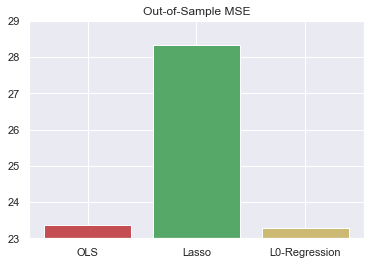

In [19]:
# Compare their performance using a bar chart
plot_bar_chart([
    mse(ytest, lr.predict(Xtest)),
    mse(ytest, lasso.predict(Xtest)),
    mse(ytest, np.dot(Xtest, beta) + intercept)
])

### Why does the Lasso perform poorly?

We did not **standardize the features to be expressed in the same units** (with an average of zero and variance of one). Contrary to OLS and L0-Regression, the Lasso is **not scale-invariant** because the budget constraint is based on the L1-norm.

Such preprocessing entails three steps, namely:

For each feature $x_l$:
1. Compute its sample average $\mu_l$ and sample standard deviation $\sigma_l$.
2. Center by subtracting $\mu_l$ from $x_l$.
3. Scale by dividing the resulting difference by $\sigma_l$.

In order to report the performance of the Lasso after applying standardization, we need to perform hyper-parameter tuning on the L1-norm penalty via cross-validation. Unfortunately, we must not use the model class `LassoCV`. This is due to the fact that standardization is not supported, and doing that beforehand over the whole dataset would contaminate the folds. In order to prevent that from happening, we will perform random search as follows:

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

np.random.seed(10101)
num_tries = 500
best_alpha = None
best_score = -np.inf

for i in range(num_tries):
    # log-linear search for alpha in the domain [0.001, 1000]
    exponent = np.random.uniform(-3, 3)
    alpha = np.power(10, exponent)
    
    pipeline = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=alpha))
    scores = cross_val_score(pipeline, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')
    
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_alpha = alpha

Let's now compare the performance of the models considered when the features are preprocessed. Notice that our user-defined function `L0-regression` does support standardization of the features:

In [21]:
# Standardize the features so they have an avg of 0 and a sample var of 1
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_std = scaler.transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

In [22]:
# OLS regression using all features
lr = linear_model.LinearRegression()
lr.fit(Xtrain_std, ytrain)

LinearRegression()

In [23]:
# Lasso with cross-validated penalization (lambda)
lasso = linear_model.Lasso(alpha=best_alpha)
lasso.fit(Xtrain_std, ytrain)

Lasso(alpha=0.007202954447381096)

In [24]:
# L0-regression where the best feature subset is selected via cross-validation
intercept, beta = L0_regression(Xtrain, ytrain, standardize=True, seed=10101)

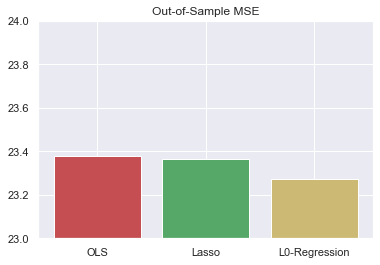

In [25]:
# Compare their performance using a Bar chart
plot_bar_chart([
    mse(ytest, lr.predict(Xtest_std)),
    mse(ytest, lasso.predict(Xtest_std)),
    mse(ytest, np.dot(Xtest_std, beta) + intercept)
])

As expected, the Lasso is better (although marginally) than OLS. This is due to the fact that the Lasso can retrieve the $\beta_{OLS}$ estimate when the budget $s$ is big enough (alternatively, when $\lambda$ is small enough). On the other hand, it is marginally worse than L0-Regression, mainly because by shrinking $\beta$ we add bias to the estimates. Furthermore, observe that L0-Regression achieved the best performance with the fewest number of features. This is convenient, as it leads to a more interpretable model.

In [26]:
ols_features = np.sum(np.abs(lr.coef_) >= 1e-8)
lasso_features = np.sum(np.abs(lasso.coef_) >= 1e-8)
l0_features = np.sum(np.abs(beta) >= 1e-8)

print("OLS regression kept {0} features.".format(ols_features))
print("The Lasso kept {0} features.".format(lasso_features))
print("L0-Regression kept {0} features.".format(l0_features))

OLS regression kept 13 features.
The Lasso kept 12 features.
L0-Regression kept 11 features.


### Final Linear Model

The previous analysis indicates that the best candidate is the model suggested by L0-Regression. The resulting equation is as follows:

\begin{equation}
\text{medv} = 22.56-1.02\text{crim}+1.46\text{zn}+0.49\text{chas}-1.93\text{nox}+2.53\text{rm}
\end{equation}

\begin{equation}
-3.48\text{dis}+2.65\text{rad}-2.22\text{tax}-1.87\text{ptratio}+1.00\text{b}-3.69\text{lstat}
\end{equation}

**Note:** The mean and variance vectors used in the standardization step can be accessed through `scaler.mean_` and `scaler.var_`, respectively. 

Since we standardized the data, the intercept represents the estimated median value (in thousands) of a house with mean values across features. Likewise, we can interpret $\beta_1=-1.02$ as the decrease in the house value when the per-capita crime rate increases by one standard deviation from the average value, all other things being equal (similar statements can be made for the rest of the features). Finally, if the main purpose of the analysis is to explain the variability in the response, having 11 features may be too much. However, remember that one can always set the number of active features to a more manageable number to ease the interpretation, perhaps at the expense of predictive power.

---
## Conclusions

It has been shown how mathematical programming can be used to perform feature selection on linear regression problems. It is in fact a good alternative to the Lasso, given that L0-Regression is scale invariant and does not add bias to the weight estimates. Furthermore, this approach is amenable to the specification of additional linear constraints (Bertsimas, 2015), such as:

- Enforcing group sparsity among features.
- Limiting pairwise multicollinearity.
- Limiting global multicollinearity.
- Considering a fixed set of nonlinear transformations.

Nevertheless, take this result with caution, as "there is no free lunch in statistics". That is, no algorithm outperforms all others under all possible datasets. Ultimately, a good data scientist should consider multiple learning algorithms when analyzing a dataset.

---
## References

1. Bertsimas, D., & King, A. (2015). OR forum—An algorithmic approach to linear regression. Operations Research, 64(1), 2-16.
2. Bertsimas, D., King, A., & Mazumder, R. (2016). Best subset selection via a modern optimization lens. The annals of statistics, 44(2), 813-852.
3. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
4. The Boston housing dataset (1996, October 10). Retrieved from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

---
# Ex: what happen if we apply Dimensionality Reduction before Linear Regression?

Try it out